In [1]:
from astropy.table import Table, hstack, vstack, unique
from astropy import units as u
import astropy.coordinates as coord
from collections import Counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import pickle
import matplotlib
from pm_func_edr3 import *
from copy import copy

In [2]:
dir = 'D:/pzivi/Research/Gurtina_Project/'

num = "1"

datasource = "allstar_Model" + num
gasmodel = Table.read(dir + "Data/"+datasource+"_Gas.fits")
dmmodel = Table.read(dir + "Data/"+datasource+"_DM.fits")

print("Number of Model " + num + " gas particles is " + str(len(gasmodel)))

print("Number of Model " + num + " DM particles is " + str(len(dmmodel)))

plotc = "tomato"  #tomato, royalblue, violet
#relc = "darkred"
#rvc = "forestgreen"

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

print(gasmodel.info())
print(dmmodel.info())


Number of Model 1 gas particles is 278864
Number of Model 1 DM particles is 14000
<Table length=278864>
 name  dtype 
----- -------
  X_0 float64
  Y_0 float64
  Z_0 float64
 Vx_0 float64
 Vy_0 float64
 Vz_0 float64
  X_G float64
  Y_G float64
  Z_G float64
 Vx_G float64
 Vy_G float64
 Vz_G float64
   RA float64
  DEC float64
 Dist float64
 PMRA float64
PMDEC float64
   RV float64
None
<Table length=14000>
 name  dtype 
----- -------
 Mass float64
  X_0 float64
  Y_0 float64
  Z_0 float64
 Vx_0 float64
 Vy_0 float64
 Vz_0 float64
  X_G float64
  Y_G float64
  Z_G float64
 Vx_G float64
 Vy_G float64
 Vz_G float64
   RA float64
  DEC float64
 Dist float64
 PMRA float64
PMDEC float64
   RV float64
None


In [3]:
#### Because this is sim data, it hasn't gone through other cuts, so I need to calculate x/y values

ra0 = np.deg2rad(13.038)
dec0 = np.deg2rad(-73.094)

center = np.asarray([ra0, dec0])


## Do this for the gas particles

tempx_gas, tempy_gas = wcs2gaiaxy(np.deg2rad(gasmodel['RA']), np.deg2rad(gasmodel['DEC']), center)

## Add the cartesian coordinates as new columns to the catalog

tempx_gas.shape = (len(tempx_gas),)
tempy_gas.shape = (len(tempy_gas),)

gasmodel.add_column(tempx_gas, name="x")
gasmodel.add_column(tempy_gas, name="y")


## Do this for the DM particles

tempx_dm, tempy_dm = wcs2gaiaxy(np.deg2rad(dmmodel['RA']), np.deg2rad(dmmodel['DEC']), center)

## Add the cartesian coordinates as new columns to the catalog

tempx_dm.shape = (len(tempx_dm),)
tempy_dm.shape = (len(tempy_dm),)

dmmodel.add_column(tempx_dm, name="x")
dmmodel.add_column(tempy_dm, name="y")

In [4]:
####
# Calculate the viewing perspective correction for each source, using the above center
####

## Systemic information to be used, values used are intended for the RG population

incl = 0.000001
thet = 0.000001
muW = -0.68         #Center of mass proper motion east in mas/yr
muN = -1.23         #CM proper motion north	in mas/yr
vsys = 148.0          #CM radial velocity in km/s
m_M = 18.91


dist0 = (10**((m_M/5.0)+1)) / 1000.0      #distance in kpc to the galaxy center

mutran = (muW**2 + muN**2)**(0.5)         #total CM proper motion

thtran = np.deg2rad(np.rad2deg(np.arctan2((-1.0*muW),muN)) + 90.0) #angle of motion for the CM PM

vtran = 4.7403885 * mutran * dist0        #total CM velocity

In [5]:
## Perform the calculation of the perspective correction and add as columns

viewcor_gas = np.zeros((len(gasmodel),3))
w, n, crv = 0, 1, 2

viewcor_gas[:,w], viewcor_gas[:,n], viewcor_gas[:,crv] = viewing_cor(vtran, thtran, vsys, dist0, ra0, dec0, \
                                                         np.deg2rad(gasmodel['RA']), np.deg2rad(gasmodel['DEC']))

gasmodel.add_column(viewcor_gas[:,w], name="muwcor")
gasmodel.add_column(viewcor_gas[:,n], name="muncor")
gasmodel.add_column(viewcor_gas[:,crv], name="rvcor")

print("")
print("Completed viewing corrections.")



## Now repeat for DM

viewcor_dm = np.zeros((len(dmmodel),3))
w, n, crv = 0, 1, 2

viewcor_dm[:,w], viewcor_dm[:,n], viewcor_dm[:,crv] = viewing_cor(vtran, thtran, vsys, dist0, ra0, dec0, \
                                                         np.deg2rad(dmmodel['RA']), np.deg2rad(dmmodel['DEC']))

dmmodel.add_column(viewcor_dm[:,w], name="muwcor")
dmmodel.add_column(viewcor_dm[:,n], name="muncor")
dmmodel.add_column(viewcor_dm[:,crv], name="rvcor")

print("")
print("Completed viewing corrections.")

D:\pzivi\Research\Gurtina_Project\smc_mcmc\pm_func_edr3.py:123: RuntimeWarning: invalid value encountered in arccos
  phi = np.arccos( (-1.0*np.cos(dec) * np.sin(ra - ra0)) / (np.sin(rho)) )



Completed viewing corrections.

Completed viewing corrections.


In [6]:
####
# Calculate the relative proper motions of the gas particles
####

relmu_gas = np.zeros((len(gasmodel), 3))
relmu_gas[:,0] = (gasmodel['PMRA']) - (-1.0*(muW + viewcor_gas[:,w]))
relmu_gas[:,n] = (gasmodel['PMDEC']) - (muN + viewcor_gas[:,n])

relmu_gas[:,crv] = (np.zeros((len(gasmodel)))) - (vsys + viewcor_gas[:,crv])

gasmodel.add_column(relmu_gas[:,0], name="rel_pmra")
gasmodel.add_column(relmu_gas[:,n], name="rel_pmdec")
gasmodel.add_column(relmu_gas[:,crv], name="rel_rv")

print("")
print("Calculated relative motions.")


####
# Calculate the relative proper motions of the DM particles
####

relmu_dm = np.zeros((len(dmmodel), 3))
relmu_dm[:,0] = (dmmodel['PMRA']) - (-1.0*(muW + viewcor_dm[:,w]))
relmu_dm[:,n] = (dmmodel['PMDEC']) - (muN + viewcor_dm[:,n])

relmu_dm[:,crv] = (np.zeros((len(dmmodel)))) - (vsys + viewcor_dm[:,crv])

dmmodel.add_column(relmu_dm[:,0], name="rel_pmra")
dmmodel.add_column(relmu_dm[:,n], name="rel_pmdec")
dmmodel.add_column(relmu_dm[:,crv], name="rel_rv")

print("")
print("Calculated relative motions.")


Calculated relative motions.

Calculated relative motions.


In [7]:
## convert this to x/y coordinates

relv_gas = np.zeros((len(gasmodel),2))

relv_gas[:,0], relv_gas[:,1] = vecwcs2gaiaxy(relmu_gas[:,0], relmu_gas[:,1], np.deg2rad(gasmodel['RA']), \
                                     np.deg2rad(gasmodel['DEC']), center)

gasmodel.add_column(relv_gas[:,0], name="rel_pmx")
gasmodel.add_column(relv_gas[:,1], name="rel_pmy")

print("")
print("Converted relative motions to Cartesian frame")

## calculate the angle of the relative vector

relposang_gas = np.rad2deg(np.arctan2(relv_gas[:,0], relv_gas[:,1]))
relposang_gas.shape = (len(gasmodel),)

gasmodel.add_column(relposang_gas, name="rel_PA")

print("")
print("Calculated angle of the relative vector")


## Repeat for DM particles

## convert this to x/y coordinates

relv_dm = np.zeros((len(dmmodel),2))

relv_dm[:,0], relv_dm[:,1] = vecwcs2gaiaxy(relmu_dm[:,0], relmu_dm[:,1], np.deg2rad(dmmodel['RA']), \
                                     np.deg2rad(dmmodel['DEC']), center)

dmmodel.add_column(relv_dm[:,0], name="rel_pmx")
dmmodel.add_column(relv_dm[:,1], name="rel_pmy")

print("")
print("Converted relative motions to Cartesian frame")

## calculate the angle of the relative vector

relposang_dm = np.rad2deg(np.arctan2(relv_dm[:,0], relv_dm[:,1]))
relposang_dm.shape = (len(dmmodel),)

dmmodel.add_column(relposang_dm, name="rel_PA")

print("")
print("Calculated angle of the relative vector")


Converted relative motions to Cartesian frame

Calculated angle of the relative vector

Converted relative motions to Cartesian frame

Calculated angle of the relative vector


In [8]:
### 

print(len(gasmodel), len(dmmodel))

gascol, dmcol = "green", "purple"

278864 14000


In [9]:
####
   # Set plotting bounds for the position and proper motion plots
####

displayvals = []

xmin, xmax, ymin, ymax = -5.0, 5.0, -6.0, 5.0

displayvals.append(xmin)
displayvals.append(xmax)
displayvals.append(ymin)
displayvals.append(ymax)

pmramin, pmramax, pmdecmin, pmdecmax, rvmin, rvmax = -1.5, 3.0, -3.5, 1.5, 50.0, 250.0

displayvals.append(pmramin)
displayvals.append(pmramax)
displayvals.append(pmdecmin)
displayvals.append(pmdecmax)
displayvals.append(rvmin)
displayvals.append(rvmax)


## Set bin widths

xwidth, ywidth = 0.4, 0.4 #0.2, 0.2

displayvals.append(xwidth)
displayvals.append(ywidth)

In [10]:
#### Now let's bin the data in X/Y space

gas_pmbins = vec_grid(gasmodel, xwidth, xmax, xmin, ywidth, ymax, ymin, 'x', 'y', 'rel_pmx', 'rel_pmy')
dm_pmbins = vec_grid(dmmodel, xwidth, xmax, xmin, ywidth, ymax, ymin, 'x', 'y', 'rel_pmx', 'rel_pmy')

pmbinx, pmbiny, pmbinpmx, pmbinpmy = 0, 1, 2, 3


## then convert them into polar coordinates

gas_pmbins_pol = np.zeros((len(gas_pmbins),4))

gas_pmbins_pol[:,0], gas_pmbins_pol[:,1], gas_pmbins_pol[:,2], gas_pmbins_pol[:,3] = \
xy2rt(gas_pmbins[:,pmbinx], gas_pmbins[:,pmbiny], gas_pmbins[:,pmbinpmx], gas_pmbins[:,pmbinpmy])

##

dm_pmbins_pol = np.zeros((len(dm_pmbins),4))

dm_pmbins_pol[:,0],dm_pmbins_pol[:,1], dm_pmbins_pol[:,2], dm_pmbins_pol[:,3] = \
xy2rt(dm_pmbins[:,pmbinx], dm_pmbins[:,pmbiny], dm_pmbins[:,pmbinpmx], dm_pmbins[:,pmbinpmy])

polr, polt, polpmr, polpmt = 0, 1, 2, 3

<Figure size 432x288 with 0 Axes>

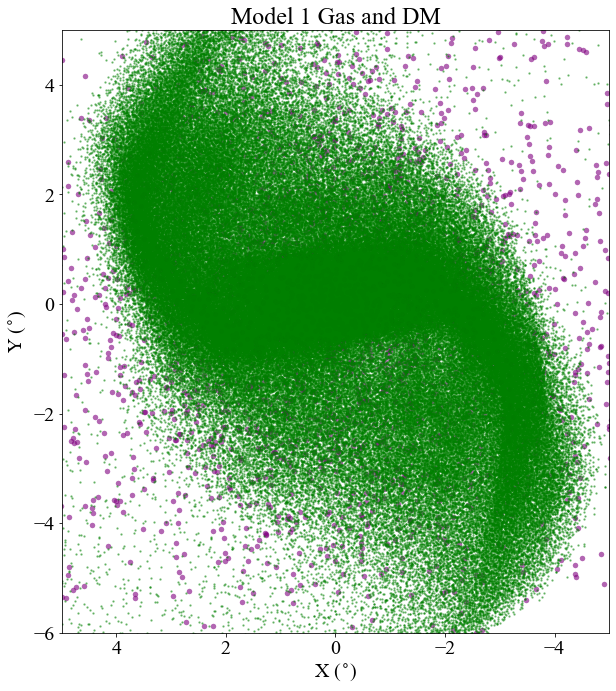

<Figure size 432x288 with 0 Axes>

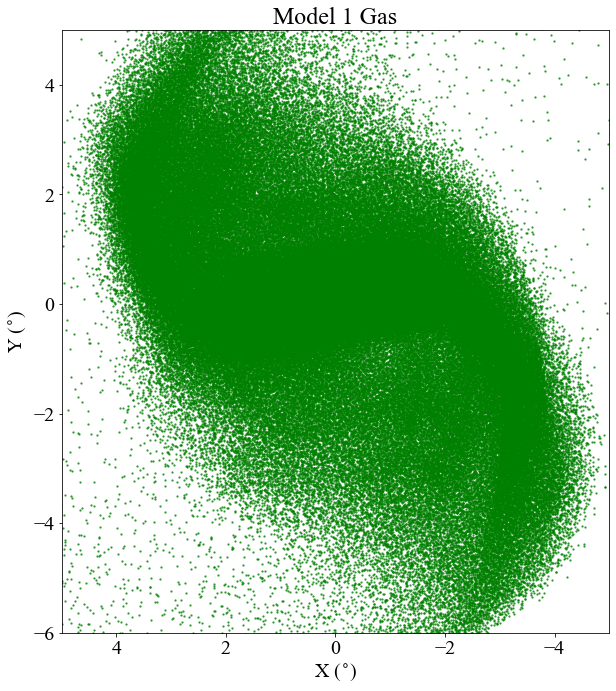

<Figure size 432x288 with 0 Axes>

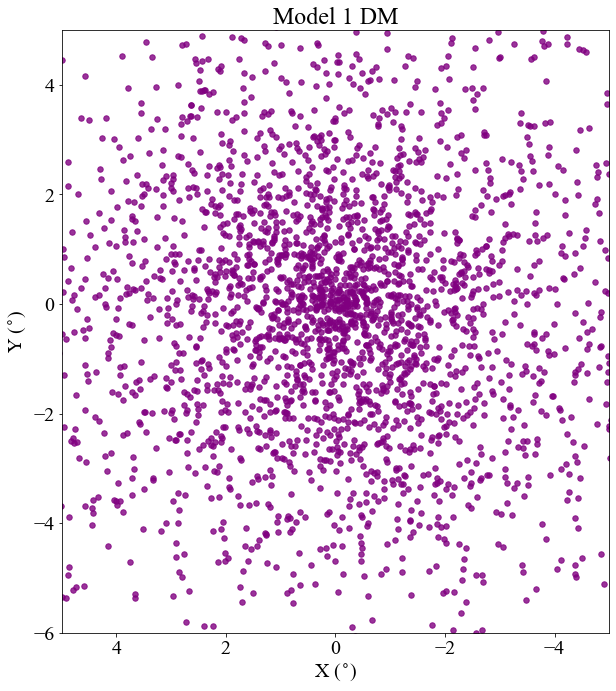

In [11]:
#### Display the data first, joint gas and DM

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(dmmodel['x'], dmmodel['y'], s=30, lw=0, marker="o", color=dmcol, alpha=0.6)
ax.scatter(gasmodel['x'], gasmodel['y'], s=8, marker=".", color=gascol, alpha=0.4)
#plt.scatter(rvgaia[:,xi], rvgaia[:,yi], s=4, lw=0, marker=".", color=rvc, alpha=0.5)

ax.set_xlabel(r'X ($^{\circ}$)')
ax.set_ylabel(r'Y ($^{\circ}$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect("equal")
ax.set_title("Model " + num + " Gas and DM")
ax.invert_xaxis()
plt.tight_layout()
fig.savefig(dir + "Plots/Model" + num + "/XY_sky_gas_dm.png", dpi=300, facecolor="white", edgecolor='none')
plt.show()


####
   # Just gas

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(gasmodel['x'], gasmodel['y'], s=8, marker=".", color=gascol, alpha=0.6)

ax.set_xlabel(r'X ($^{\circ}$)')
ax.set_ylabel(r'Y ($^{\circ}$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect("equal")
ax.set_title("Model " + num + " Gas")
ax.invert_xaxis()
plt.tight_layout()
fig.savefig(dir + "Plots/Model" + num + "/XY_sky_gas.png", dpi=300, facecolor="white", edgecolor='none')
plt.show()


####
   # Just DM

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(dmmodel['x'], dmmodel['y'], s=30, marker="o", color=dmcol, alpha=0.8)

ax.set_xlabel(r'X ($^{\circ}$)')
ax.set_ylabel(r'Y ($^{\circ}$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect("equal")
ax.set_title("Model " + num + " DM")
ax.invert_xaxis()
plt.tight_layout()
fig.savefig(dir + "Plots/Model" + num + "/XY_sky_dm.png", dpi=300, facecolor="white", edgecolor='none')
plt.show()

<Figure size 432x288 with 0 Axes>

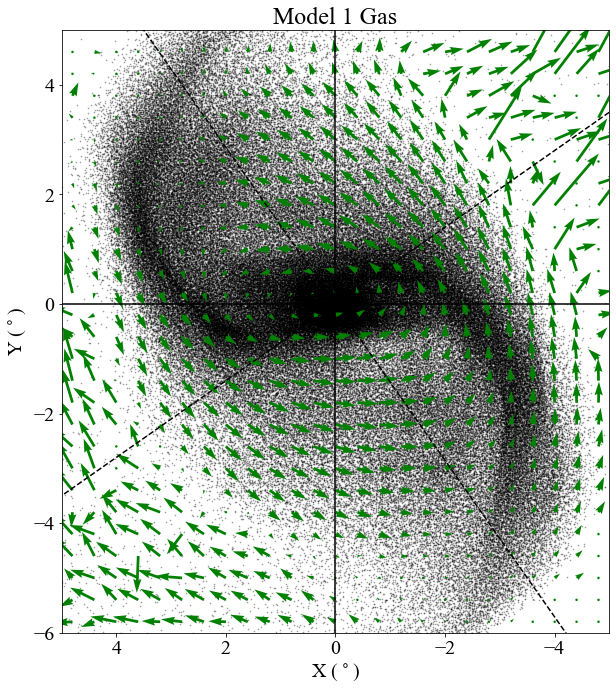

<Figure size 432x288 with 0 Axes>

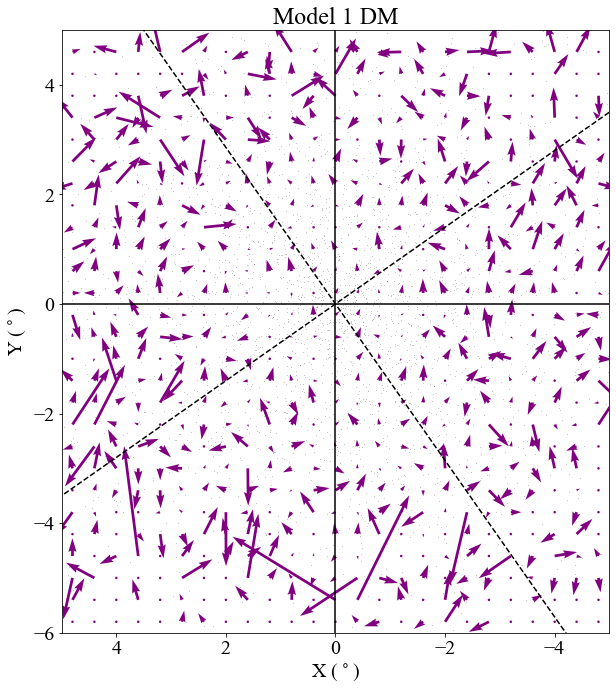

In [12]:
####
# Create the new axes for the new spatial/kinematic analysis
####

yaxis = np.asarray([[0.0, -8.0, 0.0], [0, 8.0, 0.0]])
xaxis = np.asarray([[-8.0, 0.0, 0.0], [8.0, 0.0, 0.0]])

tempcos = np.dot(yaxis[0], xaxis[0]) / (np.linalg.norm(yaxis[0])*np.linalg.norm(xaxis[0]))

#print np.rad2deg(np.arccos(tempcos))

axisrot = np.deg2rad(55.0)

newyaxis = rot3d(yaxis[:,0], yaxis[:,1], yaxis[:,2], rot_zaxis(axisrot))
newxaxis = rot3d(xaxis[:,0], xaxis[:,1], xaxis[:,2], rot_zaxis(axisrot))


tempcos2 = np.dot(newyaxis[0], newxaxis[0]) / (np.linalg.norm(newyaxis[0])*np.linalg.norm(newxaxis[0]))


#### 
# Plot averaged residual vectors for young stars
####

visscale = 5.0

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(gasmodel['x'], gasmodel['y'], s=2, color="black", marker=".", alpha=0.3)
#version with no color
q1 = ax.quiver(gas_pmbins[:,pmbinx], gas_pmbins[:,pmbiny], \
                (-1.0*visscale*gas_pmbins[:,pmbinpmx]), \
                (visscale*gas_pmbins[:,pmbinpmy]), lw=2, \
                units="xy", scale=(visscale/2.0), color=gascol, \
                width=0.05)

# tidalxy = np.asarray([[0.0, 0.0]])
# tidalvxy = np.asarray([[0.43452, -0.20803]])

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Model " + num + " Gas")
plt.tight_layout()
plt.show()
fig.savefig(dir + "Plots/Model" + num + "/vec_respm_gas.png", dpi=300, facecolor="white", edgecolor='none')


#### 
# Plot averaged residual vectors for DM particles
####

visscale = 5.0

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(dmmodel['x'], dmmodel['y'], s=2, lw=0, color="black", marker=".", alpha=0.3)
#version with no color
q1 = ax.quiver(dm_pmbins[:,pmbinx], dm_pmbins[:,pmbiny], \
                (-1.0*visscale*dm_pmbins[:,pmbinpmx]), \
                (visscale*dm_pmbins[:,pmbinpmy]), lw=2, \
                units="xy", scale=(visscale/2.0), color=dmcol, \
                width=0.05)

# tidalxy = np.asarray([[0.0, 0.0]])
# tidalvxy = np.asarray([[0.43452, -0.20803]])

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Model " + num + " DM")
plt.tight_layout()
plt.show()
fig.savefig(dir + "Plots/Model" + num + "/vec_respm_dm.png", dpi=300, facecolor="white", edgecolor='none')

<Figure size 432x288 with 0 Axes>

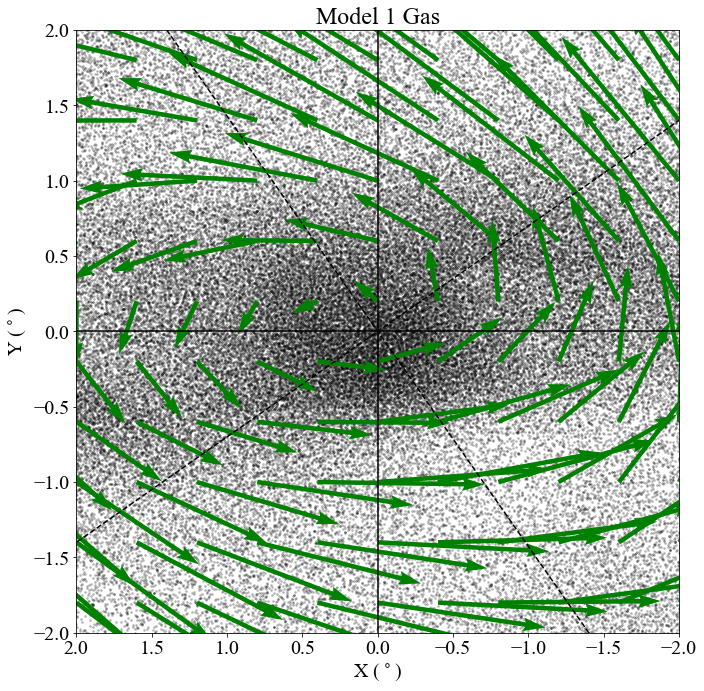

<Figure size 432x288 with 0 Axes>

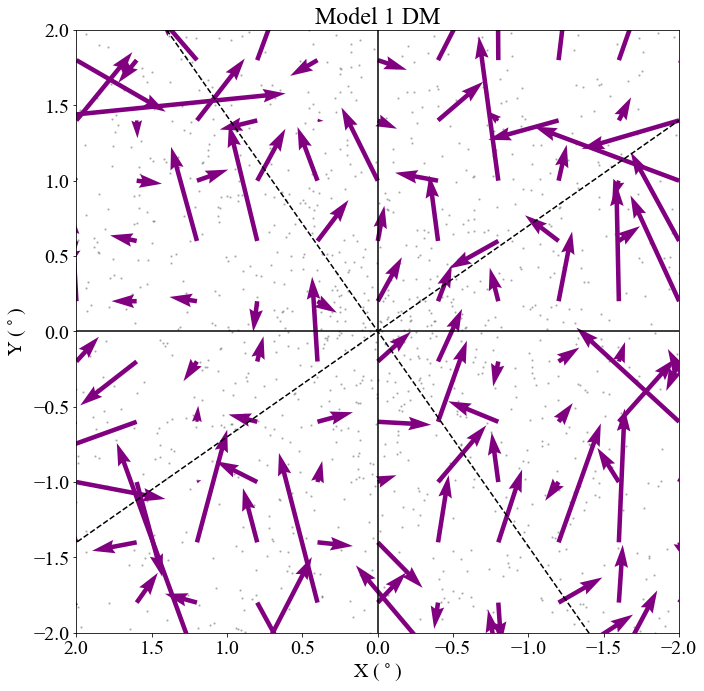

In [13]:
####
# Plot a zoomed in version on the center of the young star vector plot
####

visscale = 5.0

gas_pmbins_zoom = gas_pmbins[(abs(gas_pmbins[:,pmbinx]) < 2.5) & \
                     (abs(gas_pmbins[:,pmbiny]) < 2.5)]

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(gasmodel['x'], gasmodel['y'], s=3, color="black", marker="o", alpha=0.2)
#version with no color
q1 = ax.quiver(gas_pmbins_zoom[:,pmbinx], gas_pmbins_zoom[:,pmbiny], \
                (-1.0*visscale*gas_pmbins_zoom[:,pmbinpmx]), \
                (visscale*gas_pmbins_zoom[:,pmbinpmy]), lw=0, \
                units="xy", scale=(visscale/6.0), color=gascol, width=0.03)

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Model " + num + " Gas")
plt.tight_layout()
plt.show()
fig.savefig(dir + "Plots/Model" + num + "/vec_respm_zoom_gas.png", dpi=300, facecolor="white", edgecolor='none')


####
# Plot a zoomed in version on the center of the DM vector plot
####

visscale = 5.0

dm_pmbins_zoom = dm_pmbins[(abs(dm_pmbins[:,pmbinx]) < 2.5) & \
                     (abs(dm_pmbins[:,pmbiny]) < 2.5)]

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(dmmodel['x'], dmmodel['y'], s=2, color="black", marker="o", alpha=0.2)
#version with no color
q1 = ax.quiver(dm_pmbins_zoom[:,pmbinx], dm_pmbins_zoom[:,pmbiny], \
                (-1.0*visscale*dm_pmbins_zoom[:,pmbinpmx]), \
                (visscale*dm_pmbins_zoom[:,pmbinpmy]), lw=0, \
                units="xy", scale=(visscale/6.0), color=dmcol, width=0.03)

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Model " + num + " DM")
plt.tight_layout()
plt.show()
fig.savefig(dir + "Plots/Model" + num + "/vec_respm_zoom_dm.png", dpi=300, facecolor="white", edgecolor='none')

<Figure size 432x288 with 0 Axes>

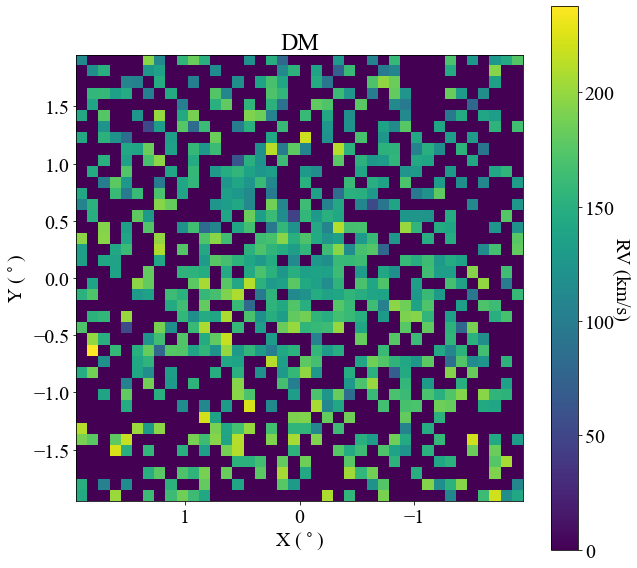

<Figure size 432x288 with 0 Axes>

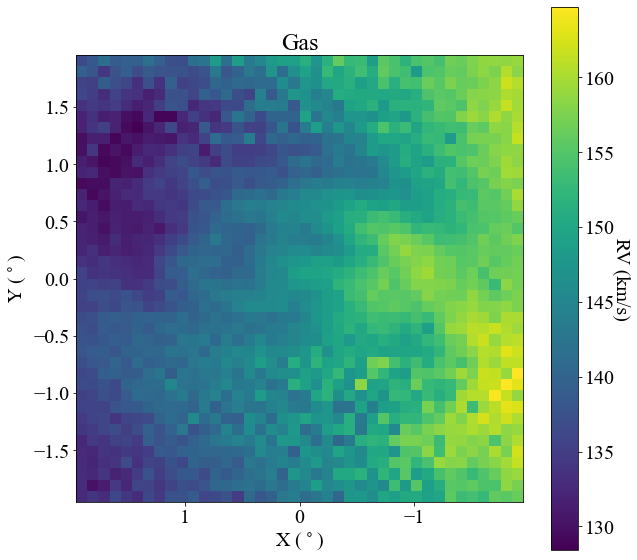

In [14]:
#my_norm = matplotlib.colors.Normalize(vmin=distlim[0], vmax=distlim[1], clip=False)
my_cmap = copy(cm.get_cmap('viridis'))
my_cmap.set_under('w')

xmax_rv, xmin_rv, ymax_rv, ymin_rv = 2.0, -2.0, 2.0, -2.0

####
   # Make RV map for old core stars
####

xgrid_dm, ygrid_dm, rvgrid_dm = create_grid(dmmodel, 0.1, xmax_rv, xmin_rv, 0.1, \
                                                           ymax_rv, ymin_rv, 'x', 'y', 'RV')

distextent = (np.amin(xgrid_dm), np.amax(xgrid_dm), \
              np.amin(ygrid_dm), np.amax(ygrid_dm))

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(rvgrid_dm, extent=distextent, origin='lower', \
                interpolation='nearest', cmap=my_cmap)

cbar = fig.colorbar(cax)
cbar.set_label("RV (km/s)", rotation=270, labelpad=15)

#q2 = plt.quiver(0.0, 0.0, (-1.0*visscale*relvel0[0]), \
#                (visscale*relvel0[1]), width=0.13, units="xy", \
#                scale=(visscale/5.0), color=relc)

#ax.plot(yaxis[:,0], yaxis[:,1], linestyle="solid", color="black")
#ax.plot(xaxis[:,0], xaxis[:,1], linestyle="solid", color="black")

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.invert_xaxis()
ax.set_title('DM')

#fig.savefig(trialdir+"/dist_map.png", dpi=300)
plt.show()


####
   # Make RV map for young core stars
####

xgrid_gas, ygrid_gas, rvgrid_gas = create_grid(gasmodel, 0.1, xmax_rv, xmin_rv, \
                                                                 0.1, ymax_rv, ymin_rv, 'x', 'y', 'RV')

distextent = (np.amin(xgrid_gas), np.amax(xgrid_gas), \
              np.amin(ygrid_gas), np.amax(ygrid_gas))

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(rvgrid_gas, extent=distextent, origin='lower', \
                interpolation='nearest', cmap=my_cmap)

cbar = fig.colorbar(cax)
cbar.set_label("RV (km/s)", rotation=270, labelpad=15)

#q2 = plt.quiver(0.0, 0.0, (-1.0*visscale*relvel0[0]), \
#                (visscale*relvel0[1]), width=0.13, units="xy", \
#                scale=(visscale/5.0), color=relc)

#ax.plot(yaxis[:,0], yaxis[:,1], linestyle="solid", color="black")
#ax.plot(xaxis[:,0], xaxis[:,1], linestyle="solid", color="black")

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.invert_xaxis()
ax.set_title('Gas')

#fig.savefig(trialdir+"/dist_map.png", dpi=300)
plt.show()